## Import Relevant packages



In [1]:
!pip install xgboost==2.0.3
!pip install lightgbm
!pip install optuna
!pip install art==6.1
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.stats as ss
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from art import text2art
from termcolor import colored

import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from math import radians, sin, cos, sqrt, atan2

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
  Using cached lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl (3.1 MB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
  Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)
  Using cached packaging-24.0-py3-none-any.whl (53 kB)
  Using cached PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (736 kB)
  Using cached

## Machine Learning

Using the top 3 numerical and 3 categorical variable identified, we train some models and determine the most suitable model to predict time taken for delivery effectively and accurately. To do this we analyze the models based on the R-squared value and Mean Squared Error of the respective models. The higher the R-squared value and the lower Mean Squared Error indicates that the model is a better one.

### 1. Random Forest Regressor

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load cleaned data into a DataFrame (df)
df = pd.DataFrame(cleaned_Data)

# Define categorical and numerical columns
categorical_cols = ['Vehicle_condition', 'Weatherconditions', 'Road_traffic_density']
numerical_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_between_restaurant_and_delivery_place(KM)']

# One-hot encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(df[categorical_cols + numerical_cols])

# Create a DataFrame for the transformed features
X = pd.DataFrame(X, columns=ct.get_feature_names_out(categorical_cols + numerical_cols))

# Define the target variable
y = df['Time_taken(min)']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Get the indices of the train and test sets
train_indices = np.arange(X_train.shape[0])
test_indices = np.arange(X_test.shape[0]) + X_train.shape[0]

# Train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error (Random Forest Regressor):', mse)

r_squared = r2_score(y_test, y_pred)
print('R-squared value (Random Forest Regressor):', r_squared)

# To use the same data splits for another model
X_train_new = X.iloc[train_indices]
X_test_new = X.iloc[test_indices]
y_train_new = y.iloc[train_indices]
y_test_new = y.iloc[test_indices]

Mean Squared Error (Random Forest Regressor): 18.12259166317741
R-squared value (Random Forest Regressor): 0.7928416041398341


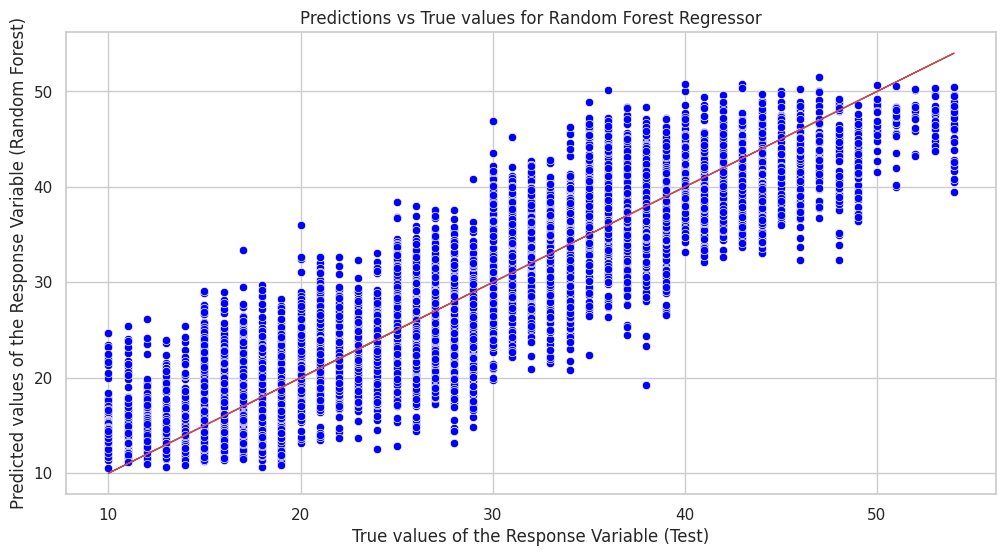

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Predictions vs True values for the Random Forest model
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')  # Using 'blue' color for Random Forest predictions
plt.plot(y_test, y_test, 'r-', linewidth=1)  # Red line for perfect prediction
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Random Forest)")
plt.title("Predictions vs True values for Random Forest Regressor")
plt.show()

Each blue dot represents a data point, where the x-coordinate is the true (actual) value from the test set, and the y-coordinate is the value predicted by the Random Forest Regressor model. There is a 45-degree line, which represents the "perfect prediction" line. If the model was making perfect predictions, all the blue dots would lie exactly on this red line. However, from this graph we can see that the blue dots are quite spread out and not cluster around the red line.

### 2. Extreme Gradient Boosting Regressor (XGBRegressor)

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb

# Load cleaned data into a DataFrame (df)
df = pd.DataFrame(cleaned_Data)

# Define categorical and numerical columns
categorical_cols = ['Vehicle_condition', 'Weatherconditions', 'Road_traffic_density']
numerical_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_between_restaurant_and_delivery_place(KM)']

# One-hot encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(df[categorical_cols + numerical_cols])

# Create a DataFrame for the transformed features
X = pd.DataFrame(X, columns=ct.get_feature_names_out(categorical_cols + numerical_cols))

# Define the target variable
y = df['Time_taken(min)']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Get the indices of the train and test sets
train_indices = np.arange(X_train.shape[0])
test_indices = np.arange(X_test.shape[0]) + X_train.shape[0]

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics for XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print('Mean Squared Error (XGBRegressor):', mse_xgb)

r_squared_xgb = r2_score(y_test, y_pred_xgb)
print('R-squared value (XGBRegressor):', r_squared_xgb)

Mean Squared Error (XGBRegressor): 15.424122836183413
R-squared value (XGBRegressor): 0.8236876599285639


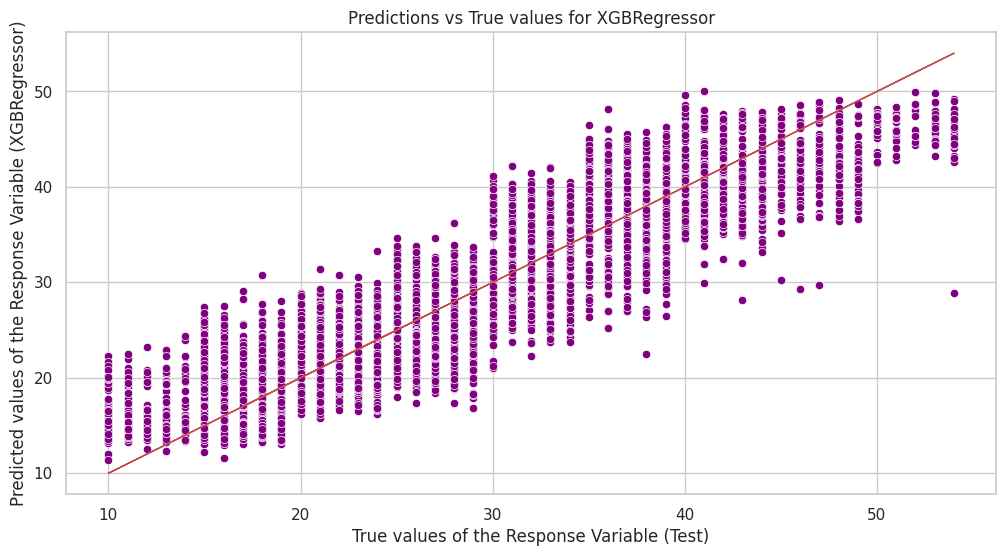

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Predictions vs the True values for the XGBoost model
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, color='purple')  # Using 'purple' color for XGBoost model
plt.plot(y_test, y_test, 'r-', linewidth=1)  # Red line for perfect prediction
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (XGBRegressor)")
plt.title("Predictions vs True values for XGBRegressor")
plt.show()


Each purple dot represents a data point, where the x-coordinate is the true (actual) value from the test set, and the y-coordinate is the value predicted by the XGBRegressor. There is a 45-degree line, which represents the "perfect prediction" line. If the model was making perfect predictions, all the purple dots would lie exactly on this red line. It is obviously that the dots are more cluster towards the red line as compare to the first graph and this suggests that this model is performing better than random forest regressor.

### 3. Light Gradient Boosting Regressor(LightGBM)

In [ ]:
# Load cleaned data into a DataFrame (df)
df = pd.DataFrame(cleaned_Data)

# Define categorical and numerical columns
categorical_cols = ['Vehicle_condition', 'Weatherconditions', 'Road_traffic_density']
numerical_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_between_restaurant_and_delivery_place(KM)']

# One-hot encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(df[categorical_cols + numerical_cols])

# Create a DataFrame for the transformed features
X = pd.DataFrame(X, columns=ct.get_feature_names_out(categorical_cols + numerical_cols))

# Define the target variable
y = df['Time_taken(min)']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Get the indices of the train and test sets
train_indices = np.arange(X_train.shape[0])
test_indices = np.arange(X_test.shape[0]) + X_train.shape[0]

# Train the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = lgb_model.predict(X_test)

# Calculate evaluation metrics for LightGBM
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
print('Mean Squared Error (LightGBM):', mse_lgb)

r_squared_lgb = r2_score(y_test, y_pred_lgb)
print('R-squared value (LightGBM):', r_squared_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 31026, number of used features: 16
[LightGBM] [Info] Start training from score 26.518017
Mean Squared Error (LightGBM): 14.878623378418407
R-squared value (LightGBM): 0.829923235651588


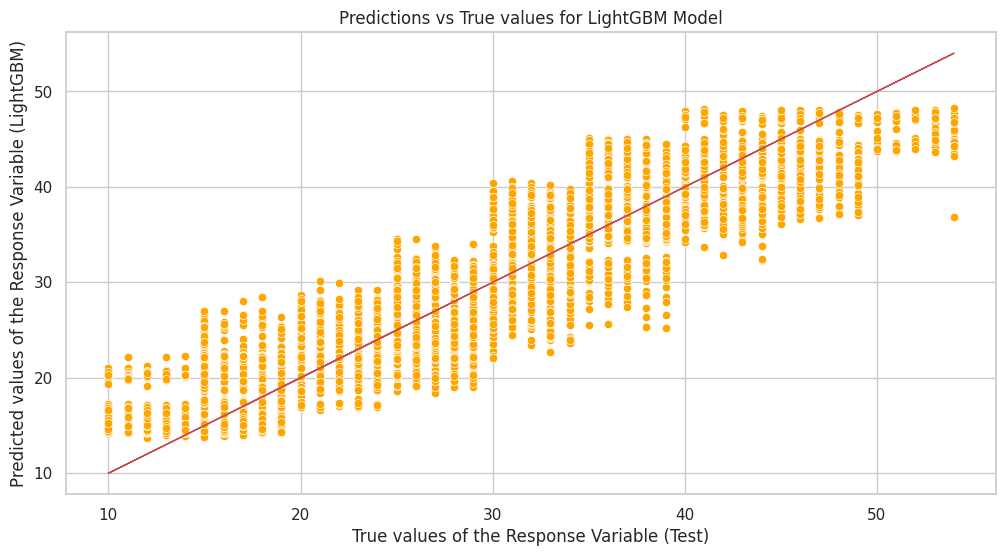

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Predictions vs the True values for the LightGBM model
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_lgb, color='orange')  # Using 'orange' color for LightGBM model
plt.plot(y_test, y_test, 'r-', linewidth=1)  # Red line for perfect prediction
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (LightGBM)")
plt.title("Predictions vs True values for LightGBM Model")
plt.show()

Each orange dot represents a data point, where the x-coordinate is the true (actual) value from the test set, and the y-coordinate is the value predicted by the LightGBM. There is a 45-degree line, which represents the "perfect prediction" line. If the model was making perfect predictions, all the orange dots would lie exactly on this red line. As compare to the first and second graph, it is obvious that the points are more cluster towards the line in this graph and this suggests that this model is performing better than Random Forest Regressor and XGBRegressor.

### 4. Support Vector Regression (SVR) 

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load cleaned data into a DataFrame (df)
df = pd.DataFrame(cleaned_Data)

# Define categorical and numerical columns
categorical_cols = ['Vehicle_condition', 'Weatherconditions', 'Road_traffic_density']
numerical_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_between_restaurant_and_delivery_place(KM)']

# One-hot encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(df[categorical_cols + numerical_cols])

# Create a DataFrame for the transformed features
X = pd.DataFrame(X, columns=ct.get_feature_names_out(categorical_cols + numerical_cols))

# Define the target variable
y = df['Time_taken(min)']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Get the indices of the train and test sets
train_indices = np.arange(X_train.shape[0])
test_indices = np.arange(X_test.shape[0]) + X_train.shape[0]

# Train the Support Vector Regression model
svr_model = SVR(kernel='rbf', gamma='auto')
svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svr = svr_model.predict(X_test)

# Calculate evaluation metrics for SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
print('Mean Squared Error (SVR):', mse_svr)

r_squared_svr = r2_score(y_test, y_pred_svr)
print('R-squared value (SVR):', r_squared_svr)

Mean Squared Error (SVR): 26.15028190861421
R-squared value (SVR): 0.7010774975145118


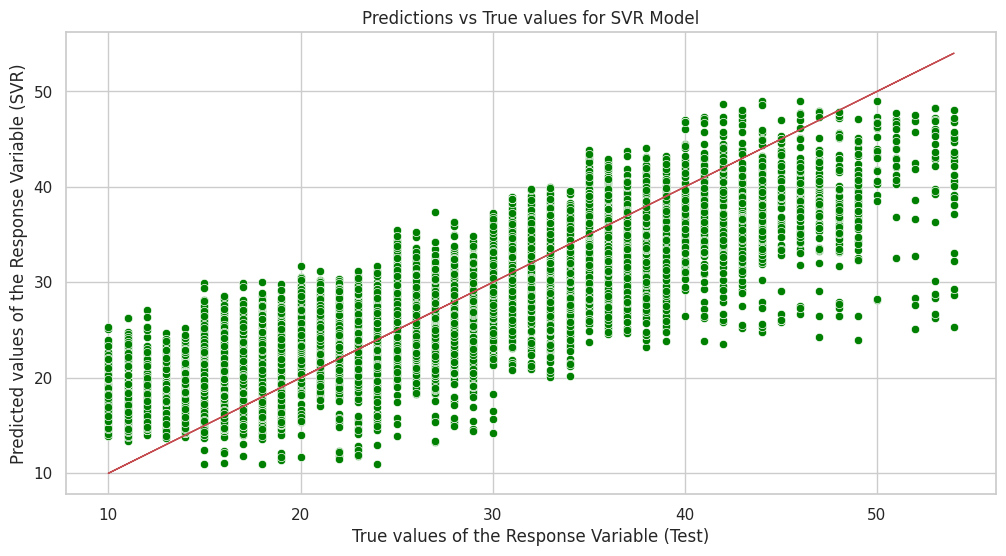

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Predictions vs the True values for the SVR model
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_svr, color='green')  # Using 'green' color for SVR model
plt.plot(y_test, y_test, 'r-', linewidth=1)  # Red line for perfect prediction
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (SVR)")
plt.title("Predictions vs True values for SVR")
plt.show()

Each green dot represents a data point, where the x-coordinate is the true (actual) value from the test set, and the y-coordinate is the value predicted by the SVR. There is a 45-degree line, which represents the "perfect prediction" line. If the model was making perfect predictions, all the green dots would lie exactly on this red line. It is obvious that the green dots are more spread out compare to the previous graph and hence suggest that this model is performing not as good as the previous LightGBM.

### 5. Ensemble Model

We will try to combine all the 4 models we have used - Random Forest Regression, Extreme Gradient Boosting Regressor(XGBRegressor), Light Gradient Boosting Regressor(LightGBM) and Support Vector Regression(SVR) into one model which should be more accurate than the individual models. However, we found out that the ensemble model does not gives the highest R squared value nor lowest mean squared error with the following possible reason:

1.  Ensemble models work best when the individual models have diverse strengths and weaknesses. However, our models are too similar such as XGBRegressor and LightGBM. Hence, they may not provide enough complementary information to improve the overall performance.
2.  Our input has a high number of features. This may cause the ensemble model struggling in finding the optimal combination of features, leading to suboptimal performance.

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb
import lightgbm as lgb

# Load cleaned data into a DataFrame (df)
df = pd.DataFrame(cleaned_Data)

# Define categorical and numerical columns
categorical_cols = ['Vehicle_condition', 'Weatherconditions', 'Road_traffic_density']
numerical_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_between_restaurant_and_delivery_place(KM)']

# One-hot encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(df[categorical_cols + numerical_cols])

# Create a DataFrame for the transformed features
X = pd.DataFrame(X, columns=ct.get_feature_names_out(categorical_cols + numerical_cols))

# Define the target variable
y = df['Time_taken(min)']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the individual models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

svr_model = SVR(kernel='rbf', gamma='auto')
svr_model.fit(X_train, y_train)

# Predict on the test set using individual models
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

# Create an ensemble model by averaging the predictions
y_pred_ensemble = (y_pred_rf + y_pred_xgb + y_pred_lgb + y_pred_svr) / 4

# Calculate evaluation metrics for the ensemble model
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
print('Mean Squared Error (Ensemble):', mse_ensemble)

r_squared_ensemble = r2_score(y_test, y_pred_ensemble)
print('R-squared value (Ensemble):', r_squared_ensemble)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 31026, number of used features: 16
[LightGBM] [Info] Start training from score 26.518017
Mean Squared Error (Ensemble): 15.811352140333579
R-squared value (Ensemble): 0.819261262039746


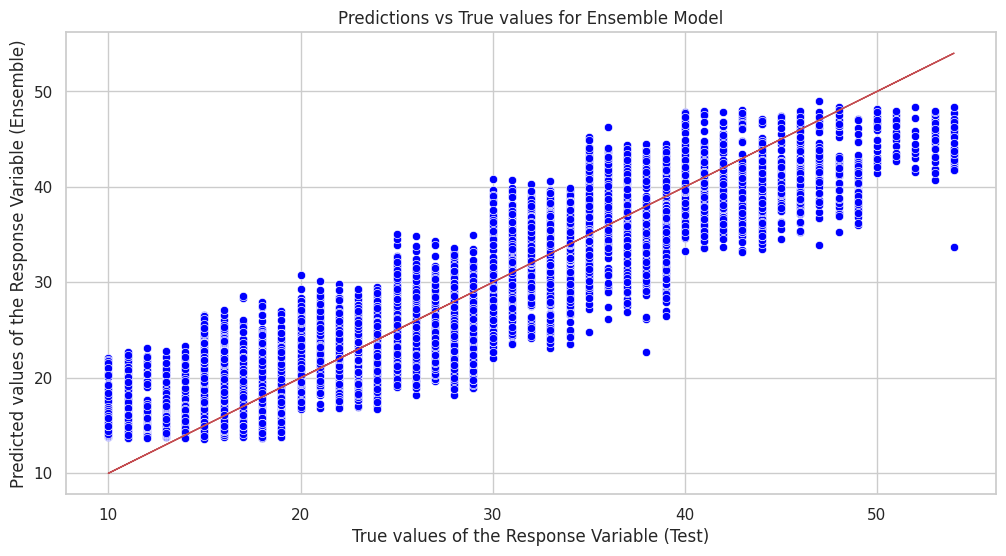

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Predictions vs the True values for the second ensemble model
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_ensemble, color='blue')
plt.plot(y_test, y_test, 'r-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Ensemble)")
plt.title("Predictions vs True values for Ensemble Model")
plt.show()

Each blue dot represents a data point, where the x-coordinate is the true (actual) value from the test set, and the y-coordinate is the value predicted by the Ensemble Model. There is a 45-degree line, which represents the "perfect prediction" line. If the model was making perfect predictions, all the blue dots would lie exactly on this red line. The blue dots are more cluster towards the red line compare to the previous graph but it is not still not the best one when compare with LightGBM.

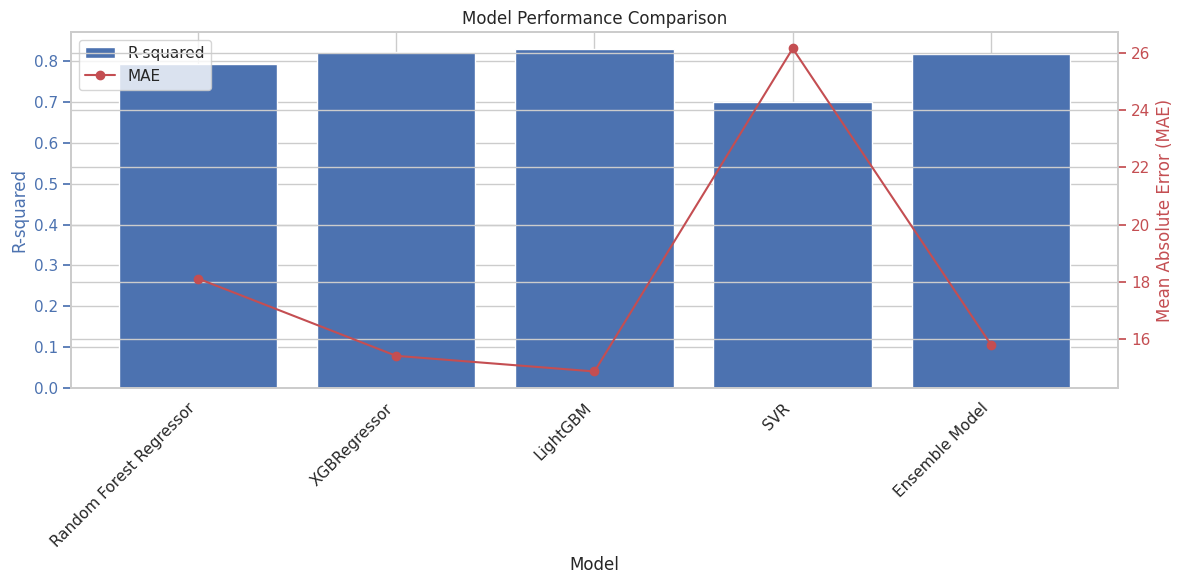

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# The data
models = ['Random Forest Regressor', 'XGBRegressor', 'LightGBM', 'SVR', 'Ensemble Model']
r2_values = [0.7928416041398341, 0.8236876599285639, 0.829923235651588, 0.7010774975145118, 0.819261262039746]
mae_values = [18.12259166317741, 15.424122836183413, 14.878623378418407, 26.15028190861421, 15.811352140333579]

# Create the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the R-squared values
ax1.bar(np.arange(len(models)), r2_values, color='b', label='R-squared')
ax1.set_xlabel('Model')
ax1.set_ylabel('R-squared', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticks(np.arange(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')

# Create a twin y-axis for the MAE values
ax2 = ax1.twinx()
ax2.plot(np.arange(len(models)), mae_values, color='r', marker='o', label='MAE')
ax2.set_ylabel('Mean Absolute Error (MAE)', color='r')
ax2.tick_params('y', colors='r')

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

| Models | R-squared value  | Mean-squared error (MSE) |
| --- | --- | --- |
| Random Forest Regressor |  0.7928416041398341 | 18.12259166317741 | 
| Extreme Gradient Boosting Regressor(XGBRegressor) |  0.8236876599285639 | 15.424122836183413 |
| Light Gradient Boosting Regressor(LightGBM) |  0.829923235651588 | 14.878623378418407 |
| Support Vector Regression(SVR) |  0.7010774975145118 | 26.15028190861421 |
| Ensemble Model |  0.819261262039746 | 15.811352140333579 |

As shown by the comparison graph plotted, **Light Gradient Boosting Regressor(LightGBM)** is the most optimal one to predict time taken for delivery with the highest R-squared value (0.8299) and lowest mean squared error (14.8786).

### Hyperparameter Tuning 

1. **Optuna** library is used to perform hyperparameter optimisation on the identified most optimal model - LightGBM. Optuna creates a study and optimizes the objective function by suggesting different combinations of hyperparameters and evaluating their performance.

2. Objective of Hyperparameter tuning is to minimize the root mean squared error (RMSE) and to check if it is possible to further improve the accuracy of LightGBM model. 

3. Hyperparameters Tuned:
`max_depth`: The maximum depth of the decision trees in the LightGBM model.
`learning_rate`: The learning rate of the LightGBM model, which controls the step size during the optimization process.
`num_leaves`: The maximum number of leaves in the decision trees.
`lambda_l1`: The L1 regularization parameter, which controls the sparsity of the model.
`lambda_l2`: The L2 regularization parameter, which controls the complexity of the model.
`bagging_freq`: The frequency of bagging (subsampling) the training data.
`bagging_fraction`: The fraction of the training data to be used in each bagging iteration.
`feature_fraction`: The fraction of features to be used in each split.
`verbosity`: The verbosity level of the LightGBM model, which controls the amount of output printed during training.

4. Early Stopping: The LightGBM model is trained with early stopping, which means the training will stop when the validation performance (in this case, RMSE) does not improve for a specified number of iterations. This helps to prevent overfitting and ensures the model generalizes well.

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def objective(trial):
    # hyperparameters
    max_depth = trial.suggest_int('max_depth', 8, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 100, 256)
    lambda_l1 = trial.suggest_loguniform('lambda_l1', 0.01, 1.0)
    lambda_l2 = trial.suggest_uniform('lambda_l2', 7.0, 8.0)
    bagging_freq = trial.suggest_int('bagging_freq', 2, 256)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.9, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.4, 0.5)
    verbosity = trial.suggest_int('verbosity', 3, 6)

    # Create the LightGBM model with early stopping
    model = lgb.LGBMRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        verbosity=verbosity,
        objective='regression',
        boosting='gbdt',
        tree_method='hist',
        random_state=42,
        early_stopping_rounds=100,  # Early stopping
        eval_metric='rmse'  # Metric used for early stopping
    )

    # Fit the model and evaluate on the test set
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    # Obtain the best iteration based on early stopping
    best_iteration = model.best_iteration_

    # Predict using the best iteration
    y_pred = model.predict(X_test, num_iteration=best_iteration)

    # Calculate MSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse


In [ ]:
# Create an Optuna study and optimize the hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[LightGBM] [Debug] Trained a tree with leaves = 112 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 112 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 83 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 112 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 112 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 112 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 112 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 112 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 112 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 7
[LightGBM] [Warning] No further splits with positive

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_max_depth,params_num_leaves,params_verbosity,state
0,0,4.026002,2024-04-17 11:01:50.799970,2024-04-17 11:01:51.472095,0 days 00:00:00.672125,0.977873,159,0.434701,0.012029,7.841331,0.196704,8,177,3,COMPLETE
1,1,4.062857,2024-04-17 11:01:51.473971,2024-04-17 11:01:52.118645,0 days 00:00:00.644674,0.929478,171,0.434217,0.914877,7.267216,0.125832,9,140,3,COMPLETE
2,2,4.027814,2024-04-17 11:01:52.119652,2024-04-17 11:01:52.769090,0 days 00:00:00.649438,0.931531,128,0.463537,0.018328,7.663621,0.244934,8,180,5,COMPLETE
3,3,4.060925,2024-04-17 11:01:52.771178,2024-04-17 11:01:53.484625,0 days 00:00:00.713447,0.913913,204,0.451003,0.029485,7.056788,0.223646,10,210,4,COMPLETE
4,4,4.120887,2024-04-17 11:01:53.485887,2024-04-17 11:01:54.197819,0 days 00:00:00.711932,0.919985,24,0.401348,0.018527,7.227961,0.271109,9,255,3,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,3.940789,2024-04-17 11:03:00.118869,2024-04-17 11:03:00.849879,0 days 00:00:00.731010,0.989150,33,0.478316,0.021539,7.710216,0.190371,8,112,4,COMPLETE
96,96,3.956724,2024-04-17 11:03:00.851245,2024-04-17 11:03:01.518476,0 days 00:00:00.667231,0.978952,33,0.479260,0.020952,7.760410,0.203064,8,112,4,COMPLETE
97,97,4.020928,2024-04-17 11:03:01.519926,2024-04-17 11:03:02.205436,0 days 00:00:00.685510,0.997464,13,0.468232,0.025002,7.800505,0.192850,8,107,4,COMPLETE
98,98,3.951881,2024-04-17 11:03:02.206568,2024-04-17 11:03:03.648293,0 days 00:00:01.441725,0.992243,22,0.484315,0.014150,7.706704,0.189573,8,116,3,COMPLETE


In [ ]:
# Print the best hyperparameters and the best score
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")
print('Best RMSE:', study.best_value)

Best params:
	max_depth: 8
	learning_rate: 0.19130271786802763
	num_leaves: 119
	lambda_l1: 0.02051465721003259
	lambda_l2: 7.665348544270411
	bagging_freq: 59
	bagging_fraction: 0.9967541119155008
	feature_fraction: 0.47221134005206716
	verbosity: 4
Best RMSE: 3.940055036746596


In [ ]:
# Train the final model with the best hyperparameters
final_model = lgb.LGBMRegressor(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=59, subsample_freq=0 will be ignored. Current value: bagging_freq=59
[LightGBM] [Warning] feature_fraction is set=0.47221134005206716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47221134005206716
[LightGBM] [Warning] lambda_l2 is set=7.665348544270411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.665348544270411
[LightGBM] [Warning] lambda_l1 is set=0.02051465721003259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02051465721003259
[LightGBM] [Warning] bagging_fraction is set=0.9967541119155008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9967541119155008
[LightGBM] [Warning] bagging_freq is set=59, subsample_freq=0 will be ignored. Current value: bagging_freq=59
[LightGBM] [Warning] feature_fraction is set=0.47221134005206716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47221134005206716
[LightGBM] [Warning] lambda_l2 is set=7.66534854427041

LGBMRegressor(bagging_fraction=0.9967541119155008, bagging_freq=59,
              feature_fraction=0.47221134005206716,
              lambda_l1=0.02051465721003259, lambda_l2=7.665348544270411,
              learning_rate=0.19130271786802763, max_depth=8, num_leaves=119,
              random_state=42, verbosity=4)

In [ ]:
# Evaluate the final model on the test set
y_pred_final = final_model.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred_final)
r_squared_final = r2_score(y_test, y_pred_final)

print('Mean Squared Error (Final Model):', mse_final)
print('R-squared value (Final Model):', r_squared_final)

[LightGBM] [Warning] bagging_freq is set=59, subsample_freq=0 will be ignored. Current value: bagging_freq=59
[LightGBM] [Warning] feature_fraction is set=0.47221134005206716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47221134005206716
[LightGBM] [Warning] lambda_l2 is set=7.665348544270411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.665348544270411
[LightGBM] [Warning] lambda_l1 is set=0.02051465721003259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02051465721003259
[LightGBM] [Warning] bagging_fraction is set=0.9967541119155008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9967541119155008
Mean Squared Error (Final Model): 15.531153057549595
R-squared value (Final Model): 0.8224642030754347


In [ ]:
# shows the scores from all trials
optuna.visualization.plot_optimization_history(study)

Objective value in graph above refers to the value that the optimization algorithm is attempting to minimize or maximize.

1. The objective value (blue dots) shows significant fluctuations throughout the optimization process, indicating that the algorithm is exploring different regions of the search space.
2. The best value (red line) is generally decreasing over the course of the optimization, suggesting that the algorithm is gradually finding better solutions.
3. There is a sharp drop in both the objective value and the best value around trial 20, indicating a major improvement in the solution quality at that point.
4. After the initial sharp drop, the best value continues to decrease gradually, but with smaller improvements, suggesting that the algorithm is refining the solution in a more stable manner.
5. Towards the end of the optimization process, the objective value and the best value converge to a similar level, indicating that the algorithm has likely found a near-optimal solution.
6. The final best value achieved appears to be around **3.95(rmse)**, which could represent the minimum or target value for the optimization problem being solved.
Overall, the plot demonstrates the typical behavior of an optimization algorithm, where it starts by exploring the search space broadly, then converges towards a near-optimal solution through gradual refinements.

In [ ]:
# Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

From the above, `feature fraction` is the most important hyperparameter followed by `learning_rate` parameter. 
| Models | R-squared value  | Mean-squared error (MSE) |
| --- | --- | --- |
| LightGBM (Before Hyperparameter tuning) |  0.829923235651588 | 14.878623378418407 |
| LightGBM (After Hyperparameter tuning) | 0.8218842199555421 | 15.581891031309757 |

#### Observations
1. It is interesting to note that the MSE of tuned LightGBM has **increased** while the R-squared value has experienced a slight decrease, implying a **decrease** in performance. 
2. Some of the possible factors behind the decrease:
a) Overfitting Prevention: During hyperparameter tuning, regularization parameters such as lambda_l1 and lambda_l2 might have been introduced to prevent overfitting. While these regularization techniques help to generalize the model better to unseen data, they could also slightly reduce the model's performance on the training set.

b) Optimization Bias: The hyperparameter optimization process aims to find the optimal set of hyperparameters that minimize the validation error (RMSE or MSE). However, this optimization is based on a finite number of trials and might not find the true optimal hyperparameters. The selected hyperparameters might not perfectly generalize to the test set, leading to a slight decrease in performance.

c) Randomness: The hyperparameter optimization process involves some level of randomness, such as the initialization of parameters and the search process itself. Due to this randomness, the performance of the model after tuning might vary slightly between different runs of the optimization process.

d) Complexity of the Dataset: The dataset might be inherently complex, making it challenging to find the optimal set of hyperparameters that can significantly improve the model's performance. In such cases, the gains from hyperparameter tuning might be marginal.

e) Evaluation Metric: The choice of evaluation metric (R-squared value and MSE) could also influence the observed results. While hyperparameter tuning aims to minimize MSE, it might not always lead to improvements in R-squared value, especially if the model becomes more conservative or biased towards the mean predictions.

#### Based on the metrics above, the untuned LightGBM model outperforms the tuned LightGBM model. While hyperparameter tuning aims to enhance model performance by optimizing the model's hyperparameters, in this specific case, the tuning process did not yield significant improvements.

Although we know that LightGBM is the most optimal models among all those 5 to find time taken for delivery, but we try to tune the hyperparameter to try if we can get better performance of this model. However, through our attempt we find out that our original model is the best one.

## K-fold Cross-validation

So far, the relative accuracies (from highest to lowest) of our models are:

1. LightGBM = 0.8299
2. Ensemble Model = 0.8193
3. XGBRegressor Model = 0.8237
4. Random Forest Regressor=  0.7928
5. Support Vector Regression = 0.7011

However, the reported model accuracies may not represent the actual or true accuracy of the models due to several reasons such as overfitting of data and data split is not representative of the overall data distribution. Hence by performing K-fold cross-validation, we can address these issues and obtain a more reliable estimate of the model's true performance using the following ways:

1. By training and evaluating the model on different subsets of the data to reduce the risk of overfitting to the training data.
2. The average of the K evaluation scores provides a more robust estimate of the model's true performance on unseen data.
3. By using multiple train-test splits, the impact of the specific data split on the model's performance is reduced.

We have determined that 5 folds give the highest accuracy.

In [ ]:
!pip install xgboost==2.0.3

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb
import lightgbm as lgb

# Load cleaned data into a DataFrame (df)
df = pd.DataFrame(cleaned_Data)

# Define categorical and numerical columns
categorical_cols = ['Vehicle_condition', 'Weatherconditions', 'Road_traffic_density']
numerical_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_between_restaurant_and_delivery_place(KM)']

# One-hot encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(df[categorical_cols + numerical_cols])
X = pd.DataFrame(X, columns=ct.get_feature_names_out(categorical_cols + numerical_cols))

# Define the target variable
y = df['Time_taken(min)']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Cross-validation for Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
rf_mse = -np.mean(rf_scores)
rf_r2 = cross_val_score(rf_model, X, y, cv=5, scoring='r2').mean()
print('Random Forest Regressor - Mean Squared Error (Cross-Validation):', rf_mse)
print('Random Forest Regressor - R-squared value (Cross-Validation):', rf_r2)

# Cross-validation for XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_mse = -np.mean(xgb_scores)
xgb_r2 = cross_val_score(xgb_model, X, y, cv=5, scoring='r2').mean()
print('XGBoost - Mean Squared Error (Cross-Validation):', xgb_mse)
print('XGBoost - R-squared value (Cross-Validation):', xgb_r2)

# Cross-validation for LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_scores = cross_val_score(lgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
lgb_mse = -np.mean(lgb_scores)
lgb_r2 = cross_val_score(lgb_model, X, y, cv=5, scoring='r2').mean()
print('LightGBM - Mean Squared Error (Cross-Validation):', lgb_mse)
print('LightGBM - R-squared value (Cross-Validation):', lgb_r2)

# Cross-validation for Support Vector Regressor
svr_model = SVR(kernel='rbf', gamma='auto')
svr_scores = cross_val_score(svr_model, X, y, cv=5, scoring='neg_mean_squared_error')
svr_mse = -np.mean(svr_scores)
svr_r2 = cross_val_score(svr_model, X, y, cv=5, scoring='r2').mean()
print('Support Vector Regressor - Mean Squared Error (Cross-Validation):', svr_mse)
print('Support Vector Regressor - R-squared value (Cross-Validation):', svr_r2)

# Train the individual models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)

# Predict on the test set using individual models
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

# Create an ensemble model by averaging the predictions
y_pred_ensemble = (y_pred_rf + y_pred_xgb + y_pred_lgb + y_pred_svr) / 4

# Calculate evaluation metrics for the ensemble model
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r_squared_ensemble = r2_score(y_test, y_pred_ensemble)
print('Mean Squared Error (Ensemble):', mse_ensemble)
print('R-squared value (Ensemble):', r_squared_ensemble)

Random Forest Regressor - Mean Squared Error (Cross-Validation): 18.109076126294344
Random Forest Regressor - R-squared value (Cross-Validation): 0.7920703899938115
XGBoost - Mean Squared Error (Cross-Validation): 15.357877009115688
XGBoost - R-squared value (Cross-Validation): 0.8236858059566783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 33094, number of used features: 16
[LightGBM] [Info] Start training from score 26.515411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points

### K-Fold Accuracies

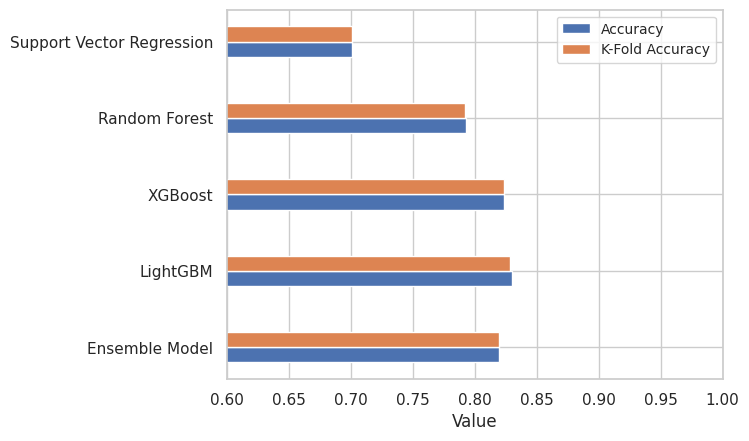

In [ ]:
fig, ax = plt.subplots()

bar_width = 0.2  # Reduce the bar width to fit all models

bar_pos1 = [0, 1, 2, 3, 4]  # Adjust positions for 5 models
bar_pos2 = [x + bar_width for x in bar_pos1]

# Sample data for k_fold_df (replace with actual values)
k_fold_df = pd.DataFrame({
    'Model': ['Ensemble Model', 'LightGBM', 'XGBoost', 'Random Forest', 'Support Vector Regression'],  # Added comma here
    'Accuracy': [0.8193, 0.8299, 0.8237, 0.7928, 0.7011],  # Sample accuracy values
    'K-Fold Accuracy': [0.8193, 0.8284, 0.8237, 0.7921, 0.7013]  # Sample k-fold accuracy values
})

ax.barh(bar_pos1, k_fold_df['Accuracy'], height=bar_width, label='Accuracy')
ax.barh(bar_pos2, k_fold_df['K-Fold Accuracy'], height=bar_width, label='K-Fold Accuracy')

ax.set_yticks([x + bar_width / 2 for x in bar_pos1])
ax.set_yticklabels(k_fold_df['Model'])

ax.set_xlabel('Value')
ax.set_xlim([0.6, 1])  # Adjust xlim based on your data

ax.legend(fontsize=10)

plt.show()

From the bar graph of comparing the accuracy of our models and K-fold cross validation, we can see that the models that we get are near to the optimal models and this confirm our result that **Light Gradient Boosting Regressor(LightGBM)** is the best models to predict time taken for delivery.

## Further analysis based on the LightGBM

### Extracting top factor by Feature Importance

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 41368, number of used features: 16
[LightGBM] [Info] Start training from score 26.553350
Feature Importance:
                                           Feature  Importance
                               Delivery_person_Age         556
Distance_between_restaurant_and_delivery_place(KM)         484
                           Delivery_person_Ratings         471
                               Vehicle_condition_0         280
                               Weatherconditions_4         208
                               Weatherconditions_0         198
                               Weatherconditions_1         191
                            Road_traffic_density_1         156
        

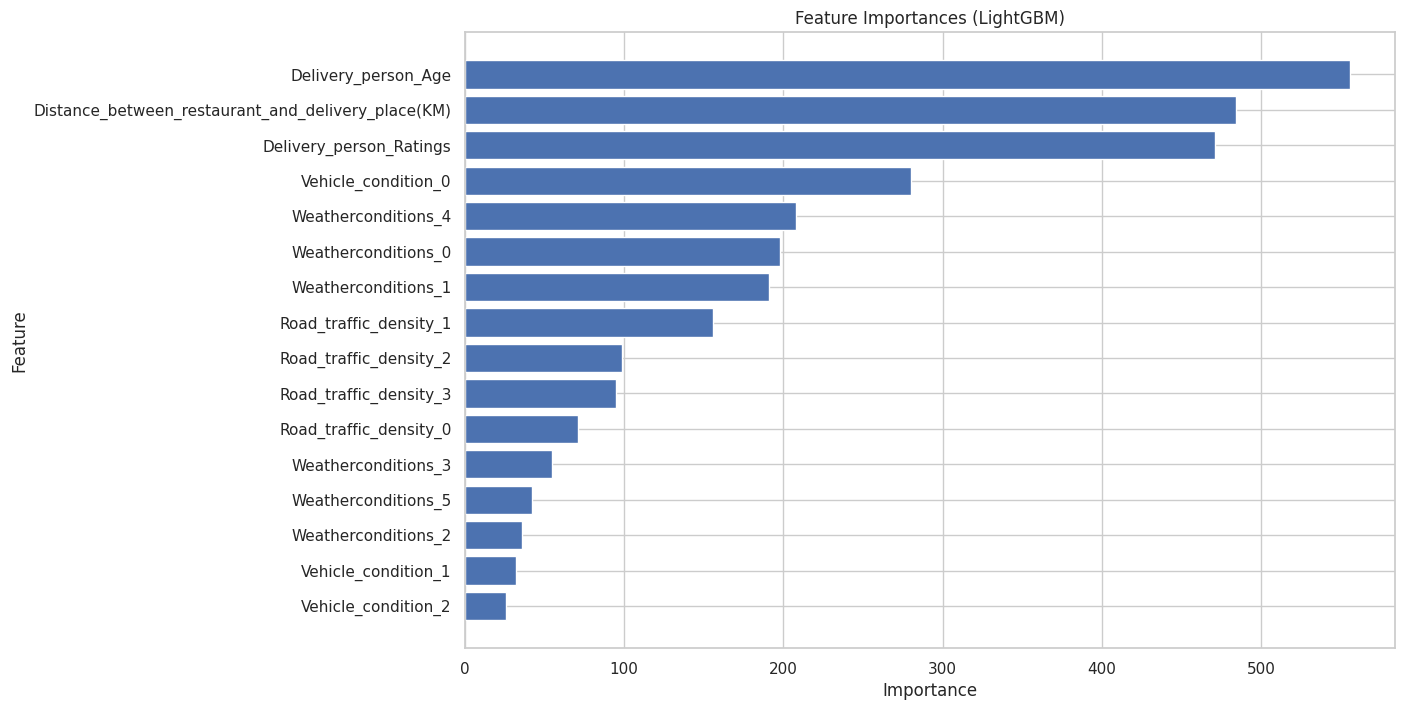

In [ ]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define categorical and numerical columns
categorical_cols = ['Vehicle_condition', 'Weatherconditions', 'Road_traffic_density']
numerical_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_between_restaurant_and_delivery_place(KM)']

# One-hot encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X_encoded = ct.fit_transform(df[categorical_cols + numerical_cols])

# Get feature names after one-hot encoding
feature_names = list(ct.named_transformers_['encoder'].get_feature_names_out(input_features=categorical_cols)) + numerical_cols

# Train the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_encoded, y)

# Get feature importances
feature_importance = lgb_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort feature importances
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importance:")
print(feature_importance_df.to_string(index=False))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])  # Reversed order
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (LightGBM)')
plt.show()


### Top factor: `Delivery_person_Age`

The feature importance in LightGBM is determined by the **"gain"** metric, which measures the improvement in the model's performance (e.g., reduction in mean squared error) when a particular feature is used to split the data in the tree-based algorithm. The features that contribute the most to the model's performance will have higher importance scores.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=44a00546-0efa-4f5e-a5a5-ac13bae81f5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>